# Download and Unzip the Data 

To download dataset from kaggele we need to download the kaggle.json file from kaggle account. This file can be created and downloaded by clicking 'Create New API Token' from the page of personal kaggle account page. Upload this file through the code below and then we can download the dataset with the name of the dataset from kaggle. 

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"njitganluan","key":"566228548a3276b77c3e9a1fb1ee0c11"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 79.1MB/s]
  0% 0.00/155k [00:00<?, ?B/s]
100% 155k/155k [00:00<00:00, 50.4MB/s]
  0% 0.00/661k [00:00<?, ?B/s]
100% 661k/661k [00:00<00:00, 85.8MB/s]
 96% 361M/377M [00:06<00:00, 40.2MB/s]
100% 377M/377M [00:06<00:00, 57.9MB/s]
100% 3.28G/3.29G [00:57<00:00, 68.2MB/s]
100% 3.29G/3.29G [00:57<00:00, 61.8MB/s]
  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 60.4kB/s]


In [0]:
# UNZIP ZIP
import zipfile
print ("Uncompressing stage_2_train_labels.csv.zip")
zip_ref = zipfile.ZipFile('/content/stage_2_train_labels.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

print ("Uncompressing stage_2_detailed_class_info.csv.zip")
zip_ref = zipfile.ZipFile('/content/stage_2_detailed_class_info.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Uncompressing stage_2_train_labels.csv.zip
Uncompressing stage_2_detailed_class_info.csv.zip


In [0]:
# UNZIP ZIP
print ("Uncompressing stage_2_train_images.zip")
zip_ref = zipfile.ZipFile('/content/stage_2_train_images.zip', 'r')
zip_ref.extractall('stage_2_train_images')
zip_ref.close()

print ("Uncompressing stage_2_test_images.zip")
zip_ref = zipfile.ZipFile('/content/stage_2_test_images.zip', 'r')
zip_ref.extractall('stage_2_test_images')
zip_ref.close()

Uncompressing stage_2_train_images.zip
Uncompressing stage_2_test_images.zip


In [0]:
!pip install pydicom

     |████████████████████████████████| 7.0MB 42.6MB/s 


In [0]:
import os, csv, random, pydicom, pylab, math, numpy as np, pandas as pd, tensorflow as tf
from skimage import io
from skimage import measure
from skimage.transform import resize
from tensorflow import keras
from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore warning

# **Overview of DICOM files and medical images**

In [0]:
patientId = train_label['patientId'][0]
dcm_file = "stage_2_train_images/%s.dcm" % patientId
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0020) Patient ID                          LO: '0004cfab-14fd-4e49-80ba-63a80b6bddd6'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient'

In [0]:
im = dcm_data.pixel_array
print(type(im))
print(im.dtype)
print(im.shape)

<class 'numpy.ndarray'>
uint8
(1024, 1024)


the size of the image is 1024*1024

## Visualizing An Example

(-0.5, 1023.5, 1023.5, -0.5)

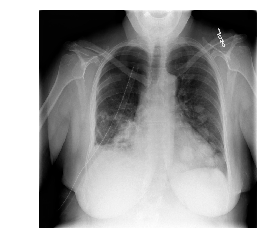

In [0]:
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

## Load pneumonia locations

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join("stage_2_train_labels.csv"), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

Take a look at the several terms in dictionary

In [0]:
print ({k: pneumonia_locations[k] for k in list(pneumonia_locations)[:5]})

{'00436515-870c-4b36-a041-de91049b9ab4': [[264, 152, 213, 379], [562, 152, 256, 453]], '00704310-78a8-4b38-8475-49f4573b2dbb': [[323, 577, 160, 104], [695, 575, 162, 137]], '00aecb01-a116-45a2-956c-08d2fa55433f': [[288, 322, 94, 135], [547, 299, 119, 165]], '00c0b293-48e7-4e16-ac76-9269ba535a62': [[306, 544, 168, 244], [650, 511, 206, 284]], '00f08de1-517e-4652-a04f-d1dc9ee48593': [[181, 184, 206, 506], [571, 275, 230, 476]]}


# **Load filenames**

Split the train images into training and validation sets, with validataion set containg10% of the data. 

In [0]:
# load and shuffle filenames
folder = "stage_2_train_images"
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = math.floor(len(filenames)*0.1)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print(str(len(train_filenames)) + ' train samples')
print(str(len(valid_filenames)) + ' valid samples')
n_train_samples = len(filenames) - n_valid_samples

24016 train samples
2668 valid samples


# **Exploration**

First plot the histogram of the number of pneumonia location identified in each image

Total train images: 26684
Images with pneumonia: 6012


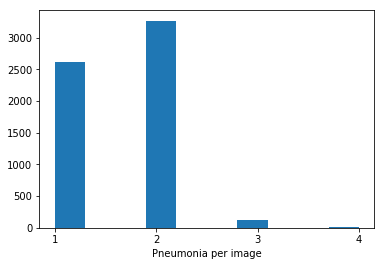

In [0]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

The percentage of images with pneumonia is 6012/26684=0.225. For images with pneumonia, most images contain 1 or 2 boxes, while only a few contains 3 or 4 boxes. 

Then plot the pneumonia location heatmap, histogram, range of box height, and histogram, range of box width. 

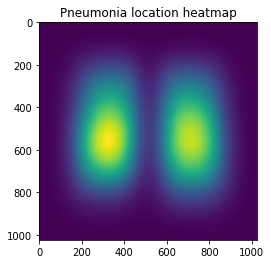

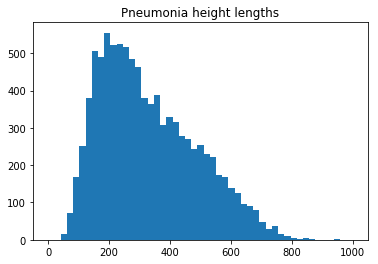

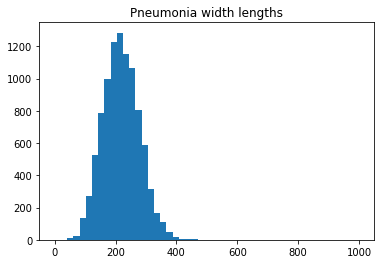

range of pneumonia height: (45, 942)
range of pneumonia width: (40, 528)


In [0]:
heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)

plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()

plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()

print('range of pneumonia height:', (np.min(hs), np.max(hs)))
print('range of pneumonia width:', (np.min(ws), np.max(ws)))

## Data generator 

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# **Network**

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# **Train network**

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = "stage_2_train_images"
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

750/750 [==============================] - 828s 1s/step - loss: 13.1347 - acc: 0.9707 - mean_iou: 0.7058 - val_loss: 15.2218 - val_acc: 0.9720 - val_mean_iou: 0.7108
Epoch 7/25
Epoch 7/25
750/750 [==============================] - 827s 1s/step - loss: 12.9382 - acc: 0.9714 - mean_iou: 0.7137 - val_loss: 12.9149 - val_acc: 0.9714 - val_mean_iou: 0.7058
Epoch 8/25
Epoch 8/25
750/750 [==============================] - 831s 1s/step - loss: 12.8840 - acc: 0.9718 - mean_iou: 0.7128 - val_loss: 13.9625 - val_acc: 0.9714 - val_mean_iou: 0.7055
Epoch 9/25
Epoch 9/25
750/750 [==============================] - 828s 1s/step - loss: 12.7551 - acc: 0.9721 - mean_iou: 0.7209 - val_loss: 14.1124 - val_acc: 0.9743 - val_mean_iou: 0.7243
Epoch 10/25
Epoch 10/25
750/750 [==============================] - 825s 1s/step - loss: 12.6039 - acc: 0.9725 - mean_iou: 0.7224 - val_loss: 12.8671 - val_acc: 0.9698 - val_mean_iou: 0.7115
Epoch 11/25
Epoch 11/25
750/750 [==============================] - 831s 1s/step 

Plot of the loss, accuracy, and mean IoU of the training and validation set. 

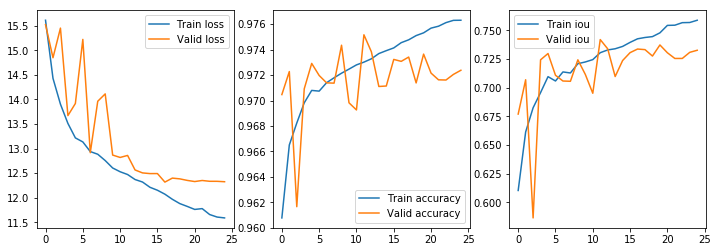

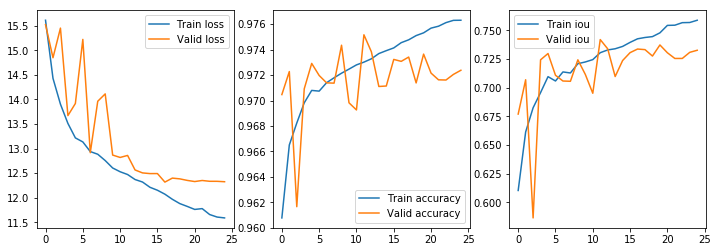

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

We can see that the validation loss reaches a plateau near the end of the training. The validation accuracy and mean IoU has big fluctuation at the begaining and tends to be more stable in the end. 

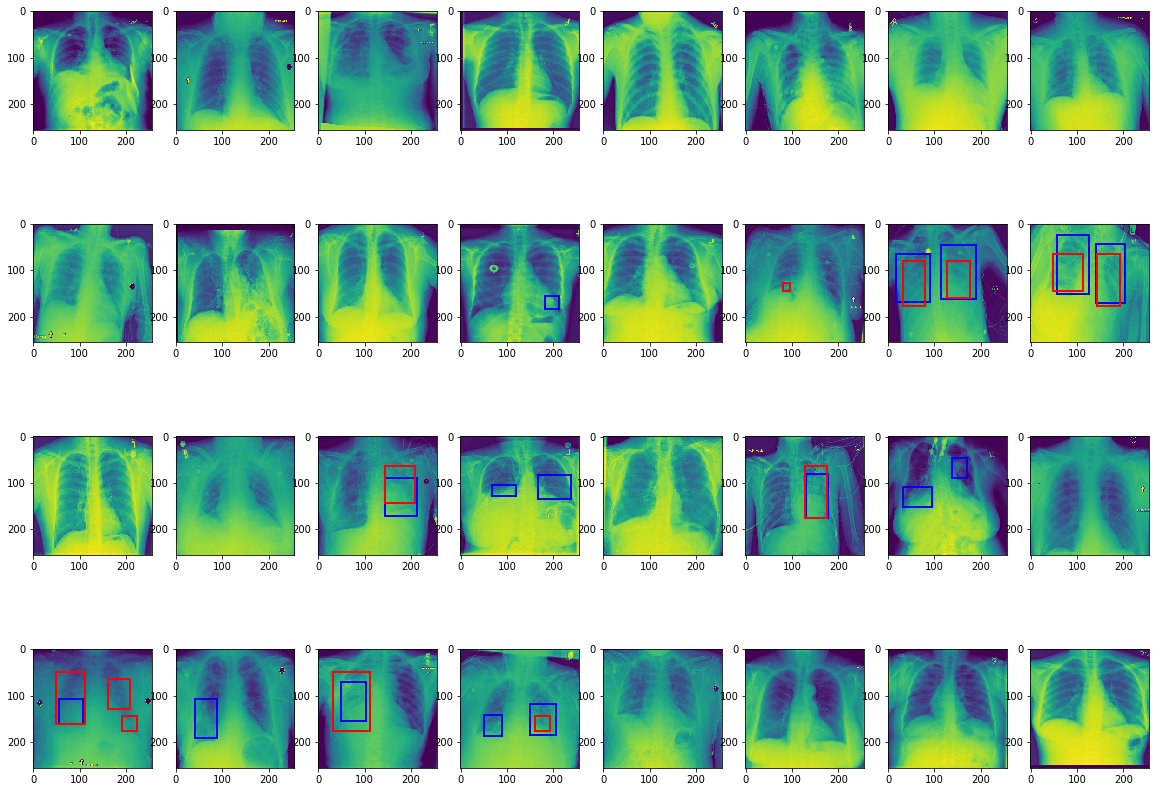

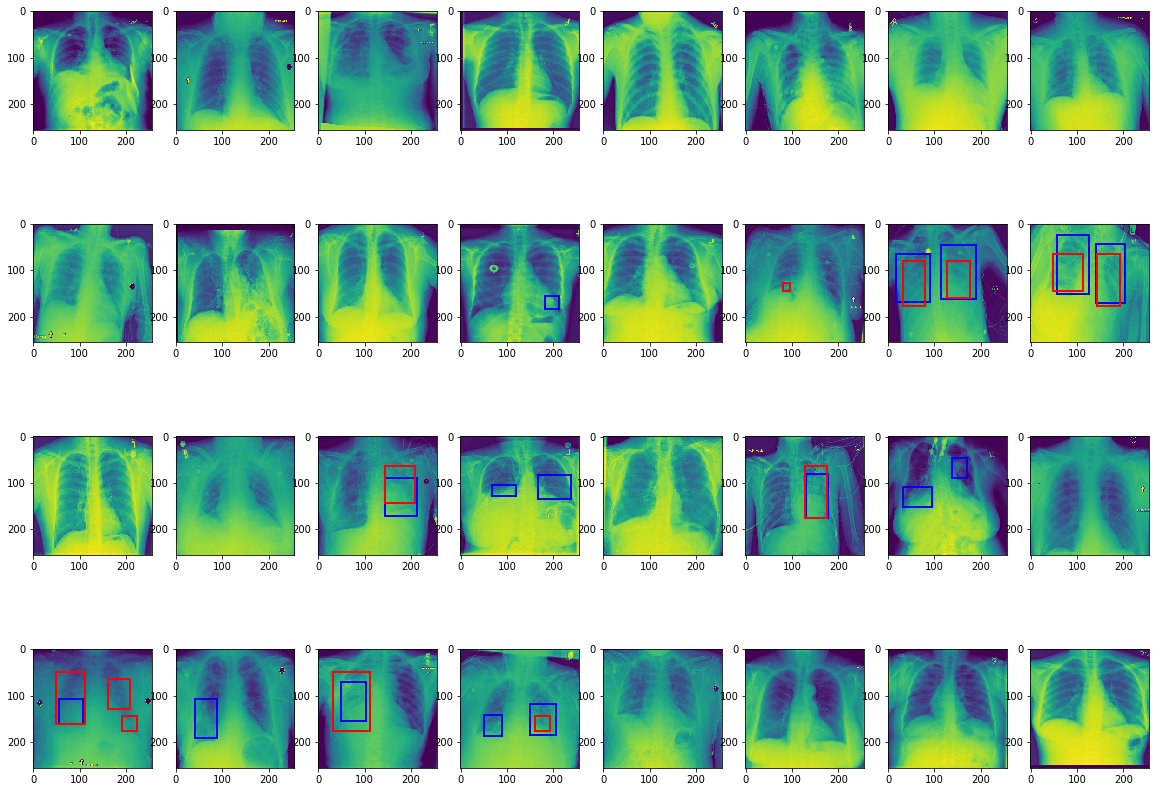

In [0]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break


In [0]:
# load and shuffle filenames
folder = 'stage_2_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
i=1
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('Submission.csv')